<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 41
# Student 1: Nikhil Patni
# Student 2: Silvia Sultana
# Student 3: Aishvarya Viswanathan

In [1]:
import requests
import io
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Applicable only if you are building it on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task ##

### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [4]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    #print(torch.tensor(queries[caseID]).shape)
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]
    #print(torch.tensor(support_set[caseID,0]).shape)

    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


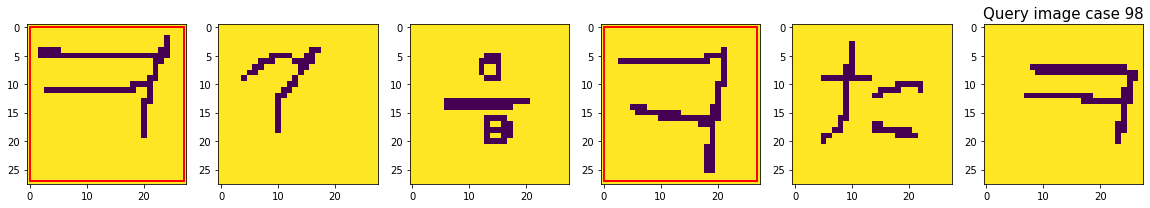

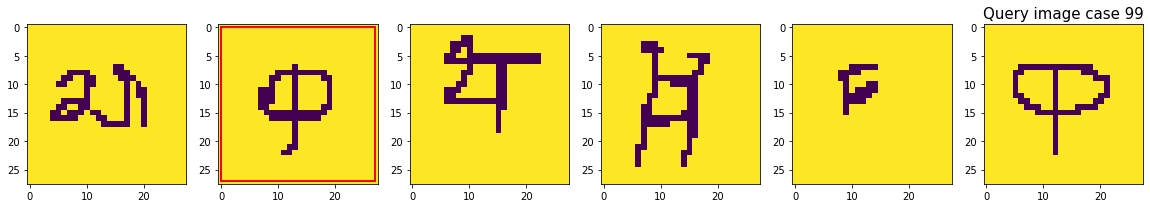

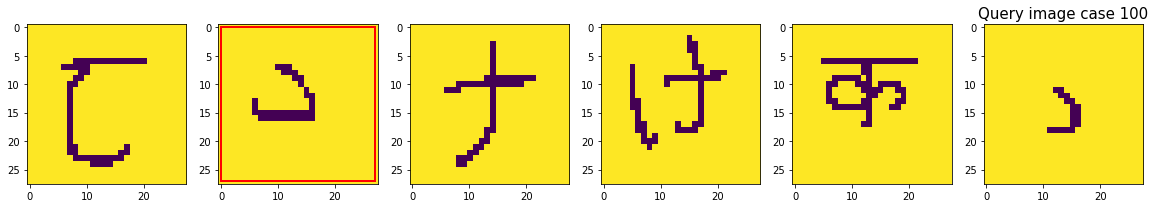

In [5]:
[plot_case(caseID,train_data,train_label) for caseID in range(98,101)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [6]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



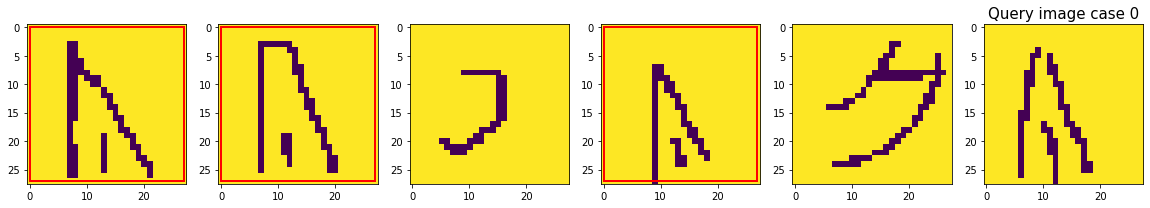

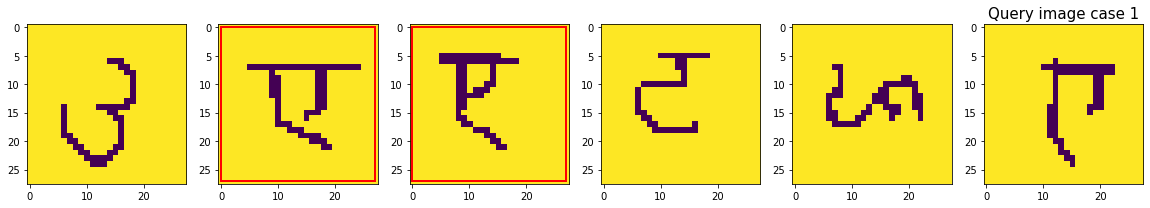

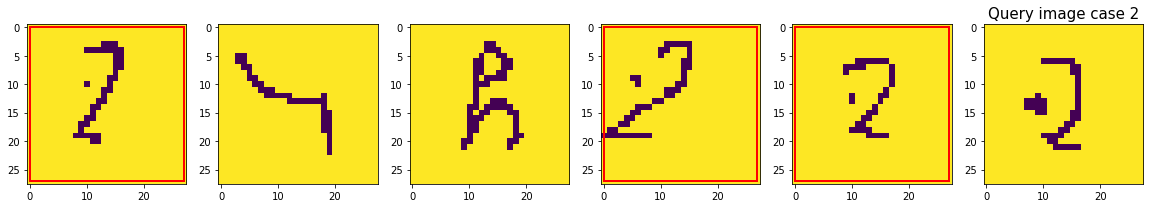

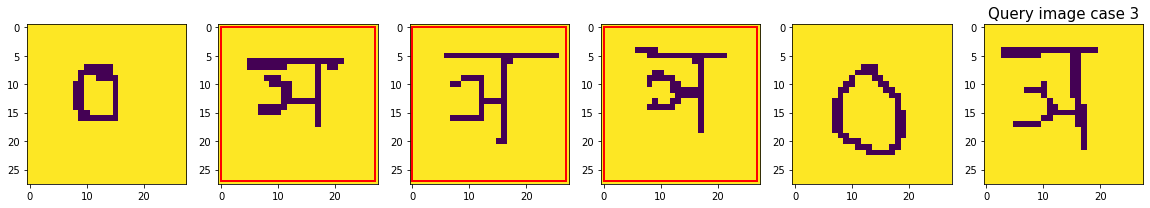

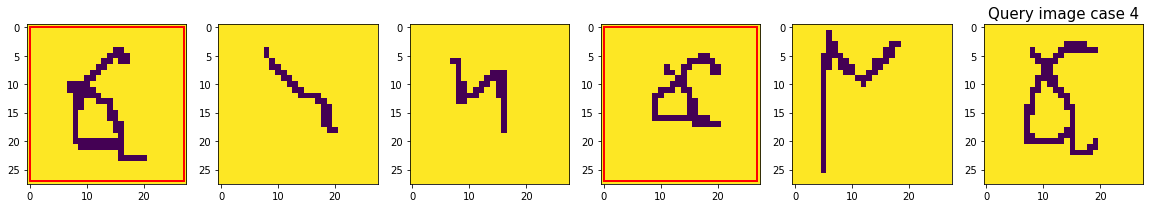

In [7]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

#Transforming and augmenting images > RandomAffine

In [9]:
from PIL import Image
import torchvision.transforms as T

def sample_and_transform(train_data,labels,sample_rate=0.5): 
  idxs = np.random.randint(0,len(train_data),int(len(train_data)*sample_rate))
  affine_transformer = T.RandomAffine(degrees=0,translate=(0.1,0.1),scale = (1,1.1),fill=1)
  new_samples = []
  new_samples_lbls = []
  for idx in idxs:
    sample = train_data[idx,:]
    new_sample = []
    new_sample_lbls = []
    for id,img in enumerate(sample):
      im = Image.fromarray(img)
      im = affine_transformer.forward(im)
      new_sample.append(np.asarray(im))
      if id < 5:
        new_sample_lbls.append(labels[idx,id])
    new_samples.append(new_sample)
    new_samples_lbls.append(new_sample_lbls)
  new_samples = np.array(new_samples)
  new_samples_lbls = np.array(new_samples_lbls)
  # Generate new sample from data augmentation and concatenate to training data
  return np.concatenate((train_data,new_samples)),np.concatenate((labels,new_samples_lbls))


## Build Sample Selector ##

In [93]:
from sklearn.model_selection import train_test_split

# choose a training dataset size and further divide it into train and validation set 80:20
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, train_size = 0.8, random_state=13)

# We do data transformations only on training data.
train_data, train_label = sample_and_transform(train_data, train_label, sample_rate = 0.5)

train_dataset=MyDataset(train_data,train_label)
val_dataset = MyDataset(val_data,val_label)
test_dataset=MyDataset(test_data,test_label)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [94]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

## Model Definition ##

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3)  
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.flatten = nn.Flatten()
        self.fcOut = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def convs(self, x):
        
        # out_dim = in_dim - kernel_size + 1
        # In = 1, 28,
        x = self.bn1(F.relu(self.conv1(x)))
        # Out = 32, 26, 26
        x = F.max_pool2d(x, (2,2))
        # Out = 32, 13, 13
        x = self.dropout2(x)
        x = self.bn2(F.relu(self.conv2(x)))
        # Out = 64, 11, 11
        x = F.max_pool2d(x, (2,2))
        # Out = 64, 5, 5
        x = self.dropout2(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.dropout2(x)
        # Out = 128, 3, 3
        return x

    def forward(self, x1, x2):
        #breakpoint()
        x1 = self.convs(x1)

        x1 = x1.view(-1, 128 * 3 * 3)
        x1 = self.flatten(x1)
        x1 = self.sigmoid(self.fc1(x1))
        # print("final x1",x1.shape)
        x2 = self.convs(x2)

        x2 = x2.view(-1, 128 * 3 * 3)
        x2 = self.flatten(x2)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.sigmoid(self.fcOut(x))
        # print("final x",x.shape)
        # Return the similarity between two images (0:Dissimilar, 1:Similar)
        return x

In [104]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseNet = Net()
siameseNet = siameseNet.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseNet)

The model architecture:

 Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcOut): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 683,969 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


## LOSS function ##

In [ ]:
# Defining a Binary Cross-Entropy Loss

class BCELoss(nn.Module):
    
    def __init__(self):
        super(BCELoss, self).__init__()
        
    def forward(self, output, label):
        loss_fn = torch.nn.BCELoss()
        loss = loss_fn(output, label)
        return loss

In [105]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseCNN-checkpoint.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

## Training & Validation ##

In [107]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    best_val_acc = 0.0
    epoch_best = 0
    epoch_val_best = 0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        tr_acc = []
        model.train()
        print("Starting epoch " + str(epoch+1))
        # ============ Training ============ #
        for train_data, labels in train_loader:
            #plot_case(99,train_data,labels)
            support_set, queries = np.split(train_data, [5], axis=1)
            labels = torch.tensor_split(labels, 5, dim=1)
            
            case_loss = 0.0
            curr_train_acc = 0.0
            train_accuracy = []
            for x in range(5):
                img1 = queries.to(device)
                x2 = support_set[:,x]
                img2 = x2.view(-1,1,28,28).to(device)
                #print("support", x2.shape)
                #break
                #img2 = support_set.to(device)
                #labels = labels[:,[0][4]].view(-1,1).to(device)
                #print(labels[4].shape)
                optimizer.zero_grad()
                outputs = model(img1, img2)

                # train accuracy calculated over a batch size
                curr_train_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(outputs.cuda())))/64
                train_accuracy.append(curr_train_acc)

                loss = criterion(outputs, labels[x].float().to(device))
                case_loss += loss.item()
                # Backward and optimize
                loss.backward()
                optimizer.step()
                
            # average out loss per case
            case_loss = case_loss/5
            running_loss += case_loss
            curr_train_acc = torch.mean(torch.stack(train_accuracy))
            tr_acc.append(curr_train_acc)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_acc = torch.mean(torch.stack(tr_acc))
        train_acc.append(avg_train_acc)
        
        # ============ Validation ============ #
        val_running_loss = 0.0
        va_acc = []
        with torch.no_grad():
            model.eval()
            for val_data, labels in val_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels = torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                curr_val_acc = 0.0
                val_accuracy = []
                for x in range(5):
                    img1 = queries.to(device)
                    #img2 = support_set.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    #labels = labels[:,x].view(-1,1).to(device)
                    outputs = model(img1, img2)
                    #print("Outputs:",outputs)
                    #print("labels:",labels[x])
                    curr_val_acc = torch.sum(torch.eq(labels[x].cuda(), torch.round(outputs.cuda())))/64 #divide by the len of the batch_size
                    val_accuracy.append(curr_val_acc)

                    loss = criterion(outputs, labels[x].float().to(device))
                    case_loss += loss.item()

                case_loss = case_loss/5
                val_running_loss += case_loss
                curr_val_acc = torch.mean(torch.stack(val_accuracy))
                va_acc.append(curr_val_acc)

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_acc = torch.mean(torch.stack(va_acc))
        val_acc.append(avg_val_acc)
        
        print('Epoch [{}/{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epoch_val_best = epoch+1
            save_checkpoint(save_name, model, optimizer, best_val_loss)

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            epoch_best = epoch+1
    
    print("Finished Training")  
    return train_losses, train_acc, val_losses, val_acc, best_val_loss, epoch_val_best, best_val_acc, epoch_best


## Evaluation ##

In [108]:
# ============ Testing ============ #
def eval(model, test_loader):
    with torch.no_grad():
        correct = 0
        count = 0
        test_accuracy = []
        for test_data, labels in test_loader:
            support_set, queries = np.split(test_data, [5], axis=1)
            labels = labels.to(device)
            labels = torch.tensor_split(labels, 5, dim=1)
            queries = queries.to(device)
            #print(labels)
            predVal = 0
            pred = []
            curr_test_acc = 0.0
            test_acc = []
            for i in range(5):
                x2 = support_set[:,i]
                testImg = x2.view(-1,1,28,28).to(device)
                #print(testImg.shape)
                output = model(queries, testImg)
                # Rounding the [0,1] output (similarity) and comparing it with label to get the test accuracy. Average over batch size
                curr_test_acc = torch.sum(torch.eq(labels[i], torch.round(output)))/10
                curr_test_acc = curr_test_acc.float()
                test_acc.append(curr_test_acc)

            cur_test_acc = torch.mean(torch.stack(test_acc))
            test_accuracy.append(cur_test_acc)

        avg_test_acc = torch.mean(torch.stack(test_accuracy))
        return avg_test_acc

In [109]:
# class ContrastiveLoss(torch.nn.Module):
#     """
#     Contrastive loss function.
#     Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
#     """

#     def __init__(self, margin=2.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, output1, output2, label):
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

#         return loss_contrastive

In [110]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseNet.parameters(), lr=1e-4, weight_decay=6e-5)
num_epochs = 200
criterion = BCELoss()

save_path = 'siameseCNN-checkpoint.pt'
train_losses, train_acc, val_losses, val_acc, best_val_loss, epoch_loss, best_val_acc, epoch_acc = train(siameseNet, train_loader, 
                                                                                  val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/200], train_loss: 0.5717, train_acc: 0.6814, val_loss: 0.5436, val_acc: 0.6778
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 2
Epoch [2/200], train_loss: 0.4859, train_acc: 0.7602, val_loss: 0.5047, val_acc: 0.7087
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 3
Epoch [3/200], train_loss: 0.4347, train_acc: 0.7955, val_loss: 0.4650, val_acc: 0.7370
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 4
Epoch [4/200], train_loss: 0.3866, train_acc: 0.8271, val_loss: 0.4501, val_acc: 0.7451
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 5
Epoch [5/200], train_loss: 0.3513, train_acc: 0.8467, val_loss: 0.4372, val_acc: 0.7571
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 6
Epoch [6/200], train_loss: 0.3252, train_acc: 0.8595, val_loss: 0.4246, val_acc: 0.7602
Model saved to ==> siameseCNN-checkpoint.pt
Starting epoch 7
Epoch [7/200], train_loss: 0.3009, train_acc: 0.8745, val_loss: 0.4164, val_acc: 0.7690
M

## Results ##

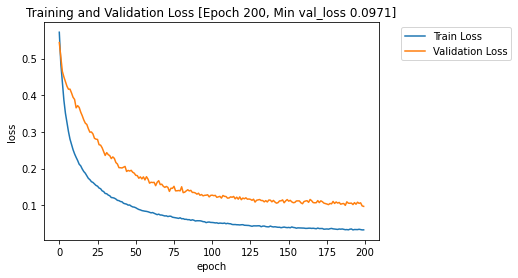

In [111]:
# plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss [Epoch {}, Min val_loss {:.4f}]".format(epoch_loss, best_val_loss))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [112]:
def convert_list_of_tensors(list_input):
    converted_tensor_list = []
    for tensor in list_input:
        converted_tensor_list.append(tensor.to('cpu'))
    return converted_tensor_list

train_acc = convert_list_of_tensors(train_acc)
val_acc = convert_list_of_tensors(val_acc)

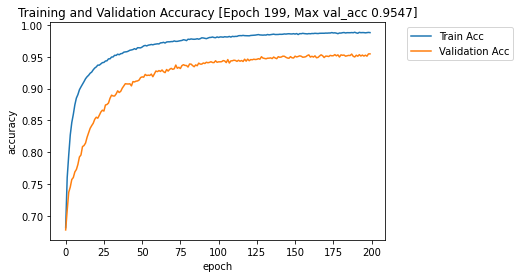

In [113]:
#plotting of training and validation accuracy
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label="Validation Acc")
plt.title("Training and Validation Accuracy [Epoch {}, Max val_acc {:.4f}]".format(epoch_acc, best_val_acc))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Accuracy on test data ##

In [116]:
# Testing on previously trained Siamese model
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(siameseNet.parameters(),lr=1e-4,weight_decay=6e-5)

best_val_loss = load_checkpoint(load_model, load_optimizer)

print('Best val_loss: {:.8f}'.format(best_val_loss))
test_acc = eval(load_model, test_loader)
print('Accuracy on test data: {:.8f}'.format(test_acc.item()))

Model loaded from <== siameseCNN-checkpoint.pt
Best val_loss: 0.09710337
Accuracy on test data: 0.91580009
